In [ ]:
pip install pandas
pip install plotly
pip install scikit-survival
pip install --upgrade nbformat
pip install matplotlib
pip install pandasgui
pip install seaborn

In [25]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import plotly.express as px

# Imporation et exploration des données

In [220]:
metabric = pd.read_csv('metabric.csv')
print(metabric.head())
len(metabric)

   Unnamed: 0        x0        x1         x2        x3   x4   x5   x6   x7  \
0           0  5.603834  7.811392  10.797988  5.967607  1.0  1.0  0.0  1.0   
1           1  5.284882  9.581043  10.204620  5.664970  1.0  0.0  0.0  1.0   
2           2  5.920251  6.776564  12.431715  5.873857  0.0  1.0  0.0  1.0   
3           3  6.654017  5.341845   8.646379  5.655888  0.0  0.0  0.0  0.0   
4           4  5.456747  5.339741  10.555724  6.008429  1.0  0.0  0.0  1.0   

      x8    duration  event  
0  56.84   99.333336      0  
1  85.94   95.733330      1  
2  48.44  140.233340      0  
3  66.91  239.300000      0  
4  67.85   56.933334      1  


1904

Le jeu de données est composé comme suit:

- Les deux variables classiquement attendues en analyse de survie: *duration* et *event*.
La variable *event* est un indicateur binaire qui représente l'occurrence ou non de l'événement d'intérêt. 
    - Si *event* = 1, cela signifie que l'événement s'est produit au moment indiqué par la variable *duration*, donc avant la fin de la période totale de suivi.  
    - Si *event* = 0, cela signifie que l'événement n'a pas eu lieu. La variable *duration* indique soit la durée totale d'observation (et donc que l'événement d'intérêt n'a pas été observé avant la fin de la période de suivi), c'est le cas dit de censure à droite, soit le moment où l'individu sort du suivi (sans que l'on sache son état à la fin de la période d'observation).

La combinaison de *duration* et *event* permet de modéliser la probabilité de l'événement au fil du temps, en tenant compte des observations qui n'ont pas abouti à l'événement.

- 9 variables supplémentaires explicatives ("features"). 
    - 5 variables numériques: x0, x1, x2, x3 et x8.
    - 4 variables catégorielles sous forme binaire (variables indicatrices ou "one-hot encoder"); x4, x5, x6 et x7.

Notons que les variables ne sont pas renseignées, nous ne savons pas à quoi elles correspondent.

Le jeu de données contient 1904 observations.

Nous supprimons la première colonne, inutile dans pour notre étude (colonne des index).

In [221]:
# Supprimer la première colonne 
data = metabric.drop(metabric.columns[0], axis=1)
print(data.head())

         x0        x1         x2        x3   x4   x5   x6   x7     x8  \
0  5.603834  7.811392  10.797988  5.967607  1.0  1.0  0.0  1.0  56.84   
1  5.284882  9.581043  10.204620  5.664970  1.0  0.0  0.0  1.0  85.94   
2  5.920251  6.776564  12.431715  5.873857  0.0  1.0  0.0  1.0  48.44   
3  6.654017  5.341845   8.646379  5.655888  0.0  0.0  0.0  0.0  66.91   
4  5.456747  5.339741  10.555724  6.008429  1.0  0.0  0.0  1.0  67.85   

     duration  event  
0   99.333336      0  
1   95.733330      1  
2  140.233340      0  
3  239.300000      0  
4   56.933334      1  


# Modélisation de la survie, méhode Kaplan-Meier

Nous écartons pour le moment les features de notre modèle.   
Pour ce faire, nous créons un dataframe *d* où ne figure que les deux variables *duration* et *event*.
Nous transformons la variable binaire *event* en variable boolléenne (TRUE ou FALSE) pour pouvoir être utilisée par les fonctions de modélisation.

In [247]:
d = data[['duration', 'event']]
d['event'] = d['event'].astype(bool)
print(d.head())

     duration  event
0   99.333336  False
1   95.733330   True
2  140.233340  False
3  239.300000  False
4   56.933334   True


C:\Users\olivi\AppData\Local\Temp\ipykernel_22324\529858963.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [248]:
import nbformat
from sksurv.nonparametric import kaplan_meier_estimator

# Calculer les temps et les probabilités de survie
times, km_survival_probabilities = kaplan_meier_estimator(d['event'], d['duration'])

# DataFrame vide pour les données de la courbe
km_proba = pd.DataFrame({
    "time": times,
    "survival_curve": km_survival_probabilities
})

# courbe de survie Kaplan-Meier
fig = px.line(
    km_proba,
    x="time",
    y="survival_curve",
    title="Courbe de survie de Kaplan-Meier",
)

# médiane de survie
fig.add_hline(
    y=0.50,
    annotation_text="Median",
    line_dash="dash",
    line_color="red",
    annotation_font_color="red",
)

# Mise à jour de la mise en page
fig.update_layout(
    height=500,
    width=800,
    xaxis_title="Temps",
    yaxis_title=r"Probabilité de survie",  
    yaxis_range=[0, 1],
)

Axe des X (Temps) : Cet axe représente le temps écoulé depuis le début de l’observation jusqu’à l’occurrence de l'événement.

Axe des Y (Probabilité de survie) : Cet axe montre la probabilité de survie jusqu'à un moment donné. Au début de l’observation (au temps zéro), la probabilité de survie est de 1 (ou 100 %), et elle diminue au fur et à mesure que le temps avance et que des événements surviennent.

La courbe de survie montre la probabilité de survie estimée à différents moments dans le temps. Chaque "marche" de la courbe indique le moment où l'événement d'intérêt a été observé pour un ou plusieurs individus.

La ligne médiane (ligne rouge) représente la médiane de survie. Le point où la courbe de survie croise cette ligne indique le moment auquel 50 % des individus de l’échantillon ont survécu.

Dans notre cas, nous pouvons observer que la décroissance de la courbe est très régulière (proche de la forme de la deuxième bissectrice, y=−x).  
Notons cependant un "plateau" de la courbe entre les jours 300 et 330, suivi d'une chute importante qui rattrape en quelque sorte le retard par rapport à la forme générale de la courbe. Dans un cas réel, il pourrait être intéressant de comprendre la raison de ce phénomène, notamment en vérifiant le protocole expérimental et l'exactitude des données pour cette période.

Élément important: La courbe atteint le zéro sur l'axe des Y à la fin de la période d'observation, ce qui signifie qu'aucun individu suivi jusqu'à la fin n'est encore vivant (vivant aus sens statistique).


In [249]:
count = data[(data['duration'] < 2029) & (data['event'] == 0)].shape[0]
print(f"Nombre d'individus sortis de l'étude avant la fin de la période d'observation : {count}")

count = data[(data['duration'] == 2029) & (data['event'] == 0)].shape[0]
print(f"Nombre d'individus toujours observés à la fin de la période d'observation n'ayant pas connu l'événement : {count}")

Nombre d'individus sortis de l'étude avant la fin de la période d'observation : 801
Nombre d'individus toujours observés à la fin de la période d'observation n'ayant pas connu l'événement : 0


## Brier score modèle Kaplan-Meier

### Création jeux d'entraînement et test

In [250]:
from sklearn.model_selection import train_test_split

def train_test_split_within(X, y, idx, **kwargs):
    """Ensure that test data durations are within train data durations."""
    X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(X, y, idx, **kwargs)
    mask_duration_inliers = y_test['duration'] < y_train['duration'].max()
    X_test = X_test[mask_duration_inliers]
    y_test = y_test[mask_duration_inliers]
    idx_test = idx_test[mask_duration_inliers]
    return X_train, X_test, y_train, y_test, idx_train, idx_test

X = data.iloc[:, :9]
y = d

X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split_within(
    X, d, np.arange(X.shape[0]), test_size=0.80, random_state=0
)

Nous avons divisé ici les données en jeux d'entraînement et de test, en s'assurant que les valeurs de durée dans le jeu de test se situent dans les limites des valeurs de durée du jeu d'entraînement grâce à un masque boolée.   
Les données sont réparties ainsi: 80% dans les dataframes X_train et y_train (entrainement) et 20% dans X_test et y_test (test).

### Préparation des données 

In [251]:

## courbe de survie sur le training set y_train
km_times_train, km_survival_curve_train = kaplan_meier_estimator(
    y_train['event'], y_train['duration'])
# km_times_train contient les instants où les événements sont observés.
# km_survival_curve_train contient les probabilités de survie estimées à ces instants.

## Interpolation sur l'ensemble de la grille de temps 
from scipy.interpolate import interp1d
km_predict = interp1d(
    km_times_train,
    km_survival_curve_train,
    kind="previous",  
    bounds_error=False,
    fill_value="extrapolate",)

## Création d'une grille de temps pour les prédictions 
def make_test_time_grid(y_train, n_steps=300):          # 300 points 
    """Bound times to the range of duration."""
    observed_duration = y_test.query("event > 0")['duration']
    
    
    span = observed_duration.max() - observed_duration.min()
    start = observed_duration.min() + 0.005 * span # Les valeurs de début et de fin de la grille sont ajustées en retirant 0,5 % aux extrémités de la durée totale (span)... 
    stop = observed_duration.max() - 0.005 * span   # ...pour éviter les erreurs potentielles aux bords de la distribution.
    return np.linspace(start, stop, num=n_steps)

time_grid = make_test_time_grid(y_train)

Ce code permet de générer une courbe de survie à partir des données d'entraînement, puis d’interpoler la probabilité de survie pour des temps arbitraires sur la grille *time_grid*.

### Courbe Brier score du modèle Kaplan Meier

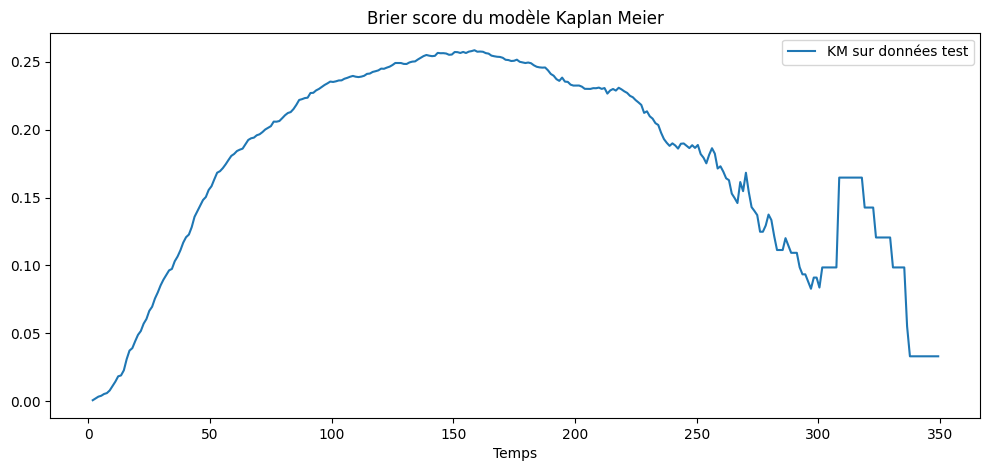

In [252]:
km_curve = km_predict(time_grid)
y_pred_km_test = np.vstack([km_curve] * X_test.shape[0])

from sksurv.metrics import brier_score
def as_sksurv_recarray(y_frame):
    """Return scikit-survival's specific target format."""
    y_recarray = np.empty(
        shape=y_frame.shape[0],
        dtype=[('event', np.bool_), ('duration', np.float64)],
    )
    y_recarray['event'] = y_frame['event']
    y_recarray['duration'] = y_frame['duration']
    return y_recarray

_, km_brier_scores = brier_score(
    survival_train=as_sksurv_recarray(y_train),
    survival_test=as_sksurv_recarray(y_test),
    estimate=y_pred_km_test,
    times=time_grid,
)

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(time_grid, km_brier_scores, label="KM sur données test");
ax.set(
    title="Brier score du modèle Kaplan Meier",
    xlabel = "Temps",
)
ax.legend();


Ce code évalue la précision des prédictions de survie Kaplan-Meier sur le jeu de test en calculant le Brier score.  
Ce score mesure l’écart entre les probabilités de survie prédites et les valeurs réelles de l'événement.  
c'est la moyenne des erreurs quadratiques entre les probabilités prédites et les résultats observés, allant de 0 à 1, où 0 indique des prédictions parfaites et 1 indique de très mauvaises prédictions. Ainsi, plus la courbe est basse, meilleure est la prédiction. 

L'erreur est plus importante dans les valeurs centrales.
A noter aussi, la remontée de l'erreur après 300, à relier à la courbe K-M sur l'ensemble des valeurs (voir plus haut)

In [147]:
from sksurv.metrics import integrated_brier_score

km_ibs_test = integrated_brier_score(
    survival_train=as_sksurv_recarray(y_train),
    survival_test=as_sksurv_recarray(y_test),
    estimate=y_pred_km_test,
    times=time_grid,
)
print(f"IBS de l'estimateur Kaplan-Meier: {km_ibs_test:.3f}")

IBS de l'estimateur Kaplan-Meier: 0.175


Ce code calcule le Brier score intégré (IBS): une mesure de l’erreur de prédiction cumulée sur toute la durée de l'étude.  
L’intêret de l'IBS est de résumer en une seule valeur l’exactitude des prédictions de survie au lieu d'un score pour chaque point de temps.    
Sa valeur est ici de *0.175*. Elle est difficilement interprétable telle quelle, et permet surtout des comparaisons avec d'autres modèles.  
À ce titre, nous pouvons le comparer à l'IBS d'un modèle de survie linéaire (qui diminue progressivement de 1 à 0 sur toute la durée de la *time_grid*).

In [148]:
# IBS courbe de survie linéaire (droite ddécroissante de 1 à 0)
linear_survival_curve = np.linspace(1.0, 0.0, time_grid.shape[0])
constant_linear_survival_curves = [linear_survival_curve] * y_test.shape[0]

linear_survival_ibs_test = integrated_brier_score(
    survival_train=as_sksurv_recarray(y_train),
    survival_test=as_sksurv_recarray(y_test),
    estimate=constant_linear_survival_curves,
    times=time_grid,)
print(f"IBS de l'estimateur linéaire: {linear_survival_ibs_test:.3f}")

IBS de l'estimateur linéaire: 0.175


Commentaire: notre modèle K-M ne fait ici pas mieux que le modèle linéaire, les résultats du calcul des IBS sont identiques.  
Cette observation est sans doute à relier à la forme relativement simple de la courbe de survie sur l'ensemble des données.

# Indice de concordance (C-index) sur modèle K-M

L'indice de concordance (C-index) est une autre mesure pour évaluer la qualité des modèles de survie.    
Le C-index évalue la capacité d'un modèle à classer correctement les individus en fonction de leur risque d'événement (ranking).   
Il représente la proportion des paires d'individus qui sont correctement classées, en cela, il ne prend pas en compte les valeurs exactes des probabilités prédites, mais à la place l'ordre des prédictions.  
Une valeur plus élevée (proche de 1) indique une meilleure capacité du modèle à classer les individus en fonction de leur risque d'événements. Un indice plus élevé est donc meilleur.

In [253]:
from sksurv.metrics import concordance_index_censored

def compute_c_index(event, duration, survival_curves):
    survival_curves = np.asarray(survival_curves)
    if survival_curves.ndim != 2:
        raise ValueError(
            "`survival_probs` must be a 2d array of "
            f"shape (n_samples, times), got {survival_curves.shape}"
        )
    assert event.shape[0] == duration.shape[0], survival_curves.shape[0]

    cumulative_hazard = survival_to_risk_estimate(survival_curves)
    metrics = concordance_index_censored(event, duration, cumulative_hazard)
    return metrics[0]

def survival_to_risk_estimate(survival_probs_matrix):
    return -np.log(survival_probs_matrix + 1e-8).sum(axis=1)

km_c_index_test = compute_c_index(y_test['event'], y_test['duration'], y_pred_km_test)
print(f"C-index de l'estimateur K-M: {km_c_index_test}")

C-index de l'estimateur K-M: 0.5


Un C-index de 0.5 signifie que sur cette métrique, notre modèle K-M ne fait pas mieux que le hasard.

Résumons les deux métriques pour nos deux modèles: Kaplan Meier et modèle linéaire:

,Model,IBS,C-index
0,Constant linear,0.1754,0.5
1,Kaplan-Meier,0.1753,0.5


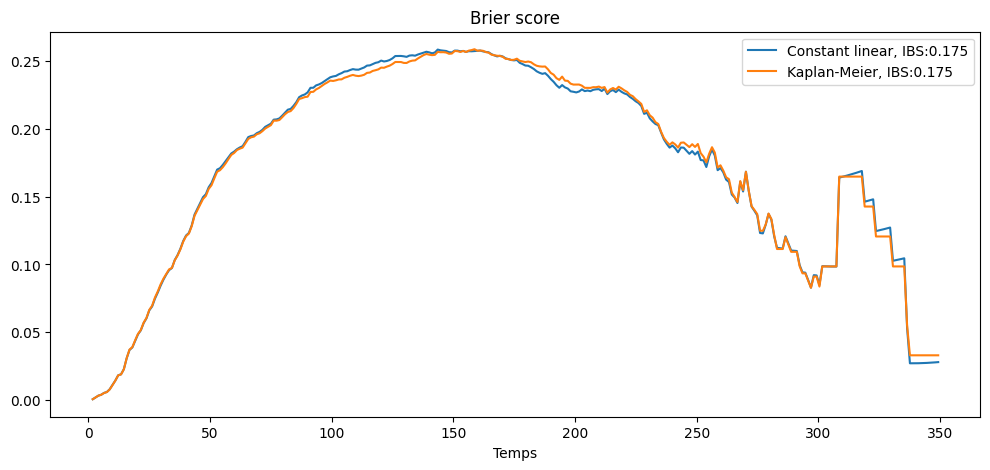

In [254]:
class SurvivalAnalysisEvaluator:
    
    def __init__(self, y_train, y_test, time_grid):
        self.model_data = {}
        self.y_train = as_sksurv_recarray(y_train)
        self.y_test = as_sksurv_recarray(y_test)
        self.time_grid = time_grid
        
    def add_model(self, model_name, survival_curves):
        survival_curves = np.asarray(survival_curves)
        _, brier_scores = brier_score(
            survival_train=self.y_train,
            survival_test=self.y_test,
            estimate=survival_curves,
            times=self.time_grid,
        )
        ibs = integrated_brier_score(
            survival_train=self.y_train,
            survival_test=self.y_test,
            estimate=survival_curves,
            times=self.time_grid,
        )
        c_index = compute_c_index(
            self.y_test['event'],
            self.y_test['duration'],
            survival_curves,
        )
        self.model_data[model_name] = {
            "brier_scores": brier_scores,
            "ibs": ibs,
            "c_index": c_index,
            "survival_curves": survival_curves,
        }

    def metrics_table(self):
        return pd.DataFrame([
            {
                "Model": model_name,
                "IBS": info["ibs"],
                "C-index": info["c_index"],
            }
            for model_name, info in self.model_data.items()
        ]).round(decimals=4)
        
    def plot(self, model_names=None):
        if model_names is None:
            model_names = list(self.model_data.keys())
        fig, ax = plt.subplots(figsize=(12, 5))
        self._plot_brier_scores(model_names, ax=ax)

    def _plot_brier_scores(self, model_names, ax):
        for model_name in model_names:
            info = self.model_data[model_name]
            ax.plot(
                self.time_grid,
                info["brier_scores"],
                label=f"{model_name}, IBS:{info['ibs']:.3f}");
        ax.set(
            title="Brier score",
            xlabel="Temps",
        )
        ax.legend()
        
    def __call__(self, model_name, survival_curves, model_names=None):
        self.add_model(model_name, survival_curves)
        self.plot(model_names=model_names)
        return self.metrics_table()

evaluator = SurvivalAnalysisEvaluator(y_train, y_test, time_grid)
evaluator.add_model("Constant linear", constant_linear_survival_curves)
evaluator.add_model("Kaplan-Meier", y_pred_km_test)
evaluator.plot()
evaluator.metrics_table()

Où l'on observe en effet que le modèle K-M obtient des résultats quasi-identiques au modèle linéaire.

# Modèle Cox 


Un modèle de Cox, ou modèle de risques proportionnels de Cox (Cox Proportional Hazards Model), est une méthode de régression utilisée en analyse de survie qui **tient compte des effets des covariables**.  

Calculons les probabilités de survie des 10 premiers individus du dataframe *X_test*:

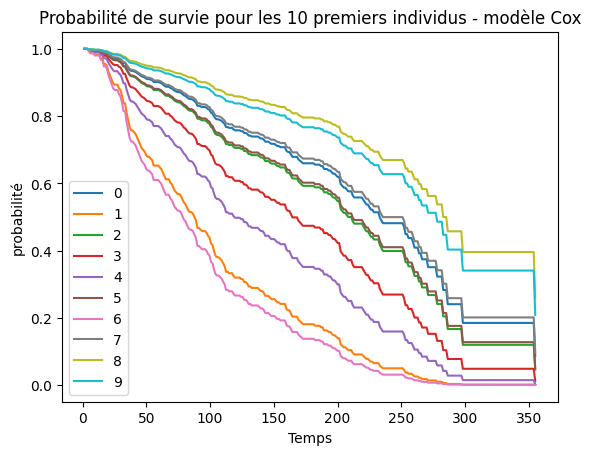

In [218]:
from sksurv.linear_model import CoxPHSurvivalAnalysis
cox_ph = CoxPHSurvivalAnalysis(alpha=1e-4)  

# Entraînement du modèle Cox
cox_ph.fit(X_train, as_sksurv_recarray(y_train))
# Prédiction des fonctions de survie sur les données de test
cox_ph_survival_funcs = cox_ph.predict_survival_function(X_test)

# Graphique des probabilités de survie pour les 10 premières observations de X_test
fig, ax = plt.subplots()
time_grid = np.linspace(y_train['duration'].min(), y_train['duration'].max(), num=300)

for idx, cox_ph_survival_func in enumerate(cox_ph_survival_funcs[:10]):
    survival_curve = cox_ph_survival_func(time_grid)
    ax.plot(time_grid, survival_curve, label=idx)

ax.set(
    title="Probabilité de survie pour les 10 premiers individus - modèle Cox",
    xlabel="Temps",
    ylabel="probabilité",
)
plt.legend()
plt.show()

Les courbes représentent la probabilité de survie estimée par le modèle de Cox pour les 10 premièrs individus de *X_test*.  
Notons que les courbes sont assez différerntes les unes des autres (en fonction des features), cependant nous retrouvons le plat caractéristique après 300 jours déjà observé sur le modèle Kaplan Meier.

### Poids des features

Nous pouvons afficher les poids des différents features dans notre modèle.

C:\Users\olivi\AppData\Local\Temp\ipykernel_22324\174956705.py:22: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




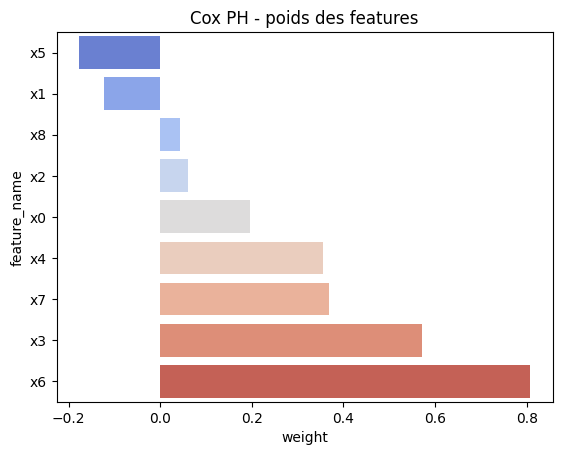

In [236]:
from sksurv.linear_model import CoxPHSurvivalAnalysis
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Extraction des noms des features et des poids
feature_names = X_train.columns.tolist()
weights = cox_ph.coef_

# Créer un DataFrame avec les noms des features et leurs poids
features = (
    pd.DataFrame(
        dict(
            feature_name=feature_names,
            weight=weights,
        )
    )
    .sort_values("weight")
)

# Visualiser l'importance des features 
ax = sns.barplot(
    data=features, 
    y="feature_name", 
    x="weight", 
    orient="h", 
    palette="coolwarm"  # Palette de couleurs coolwarm (vous pouvez choisir une autre palette)
)
ax.set_title("Cox PH - poids des features")
plt.show()



Interprétation des coefficients :
Un coefficient positif indique que l'augmentation de cette variable augmente le risque de l'événement.  
Un coefficient négatif indique au contraire que l'augmentation de la variable est associée à une réduction du risque de l'événement.  

Par exemple, avec le coefficient de *x6* à 0.8, cela signifie que pour chaque augmentation de 1 unité de la feature *x6*, le risque relatif augmente de exp(0.8) ≈ 2.2 fois.


Calculons le Brier score et le C-index pour le modèle Cox et comparons le aux modèles précédents.

,Model,IBS,C-index
0,Constant linear,0.1754,0.5000
1,Kaplan-Meier,0.1753,0.5000
2,Cox PH,0.1565,0.6299


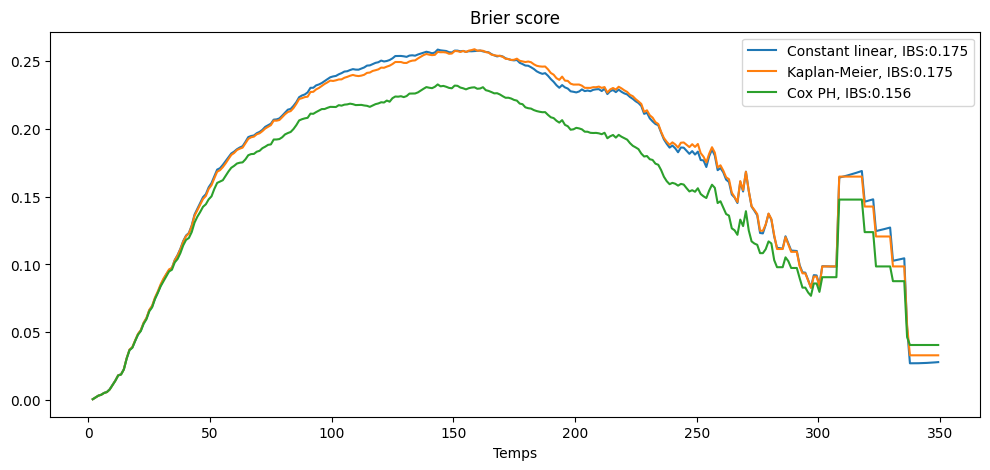

In [255]:
cox_survival_curves = np.vstack(
    [
        cox_ph_survival_func(time_grid)
        for cox_ph_survival_func in cox_ph_survival_funcs
    ]
)
evaluator("Cox PH", cox_survival_curves)

Le modèle Cox fait mieux sur les deux métriques.   
La courbe du Brier score montre que le résultat est meilleur sur toute la durée de l'étude et que la dofférence est encore plus marquée dans la zone centrale, où l'erreur est la plus importante. 

# COX polynomial (avec interactions)

Dans un modèle de Cox polynomial, on introduit les puissances pour les covariables et les interactions entres-elles.
Par exemple pour 2 covariable avec au degré 2, cela donne:  

$h(t | X) = h_0(t) \cdot \exp(\beta_1 X_1 + \beta_2 X_2 + \beta_3 X_1^2 + \beta_4 X_2^2 + \beta_5 X_1 \cdot X_2)$

Ce modèle peut mieux ajuster des relations complexes entre les covariables et le risque, mais au prix d’une complexité accrue et d’un risque de surajustement si les termes polynomiaux sont trop nombreux.  
Le modèle Cox polynomial est égalemnet plus couteux en calculs et moins facilement interprétable.

Avant de comparer le modèle de Cox polynomial, essayons de choisir la meilleure valeur de alpha.
ALpha contrôle l’intensité de la régularisation appliquée au modèle pour limiter les valeurs extrêmes des coefficients des variables. La régularisation est donc une technique pour prévenir le sur-apprentissage.  
Nous utilisons le Brier score comme métrique de sélection.

### Choix de la valeur alpha

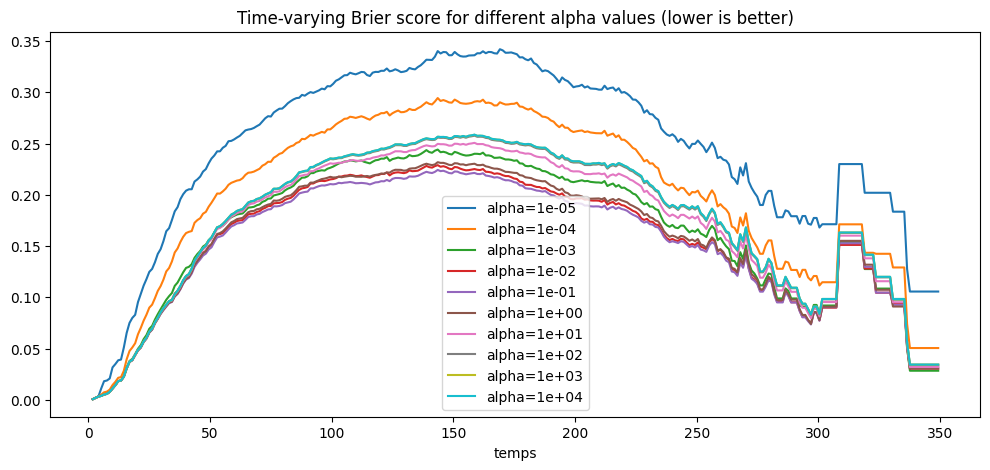

In [237]:
from sklearn.pipeline import make_pipeline
from sklearn.kernel_approximation import Nystroem
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import SplineTransformer
from sksurv.linear_model import CoxPHSurvivalAnalysis

# Valeurs de alpha à tester (facteur 10 à chaque fois)
alpha_values = [10**i for i in range(-5, 5)]  # De 1e-4 à 1e5 (10 valeurs)

# Créer un tableau pour stocker les Brier scores
brier_scores_per_alpha = {}

# Boucle pour tester différentes valeurs de alpha
for alpha in alpha_values:
    # Créer le pipeline avec la valeur de alpha en cours
    poly_cox_ph = make_pipeline(
        column_transformer,
        Nystroem(kernel="poly", degree=2, n_components=300),
        CoxPHSurvivalAnalysis(alpha=alpha)
    )
    
    # Entraîner le modèle sur les données d'entraînement
    poly_cox_ph.fit(X_train, as_sksurv_recarray(y_train))

    # Prédire les fonctions de survie sur les données de test
    poly_cox_ph_survival_funcs = poly_cox_ph.predict_survival_function(X_test)

    # Empiler les prédictions pour chaque instance de test
    y_pred_poly_cox_ph_test = np.vstack(
        [func(time_grid) for func in poly_cox_ph_survival_funcs]
    )

    # Calculer le Brier score pour le modèle polynomial Cox PH
    _, poly_cox_ph_brier_scores = brier_score(
        survival_train=as_sksurv_recarray(y_train),
        survival_test=as_sksurv_recarray(y_test),
        estimate=y_pred_poly_cox_ph_test,
        times=time_grid,
    )

    # Stocker les Brier scores pour cette valeur de alpha
    brier_scores_per_alpha[alpha] = poly_cox_ph_brier_scores

# Tracer les courbes des Brier scores pour chaque valeur de alpha
fig, ax = plt.subplots(figsize=(12, 5))
for alpha, brier_scores in brier_scores_per_alpha.items():
    ax.plot(time_grid, brier_scores, label=f"alpha={alpha:.0e}")

# Paramètres du graphique
ax.set(
    title="Time-varying Brier score for different alpha values (lower is better)",
    xlabel="temps",
)
ax.legend(loc="best")
plt.show()


Nous constatons que la meilleure valeur de alpha parmi celles testées ici est de *0.1*.  
Essayons d'optimiser cette valeur

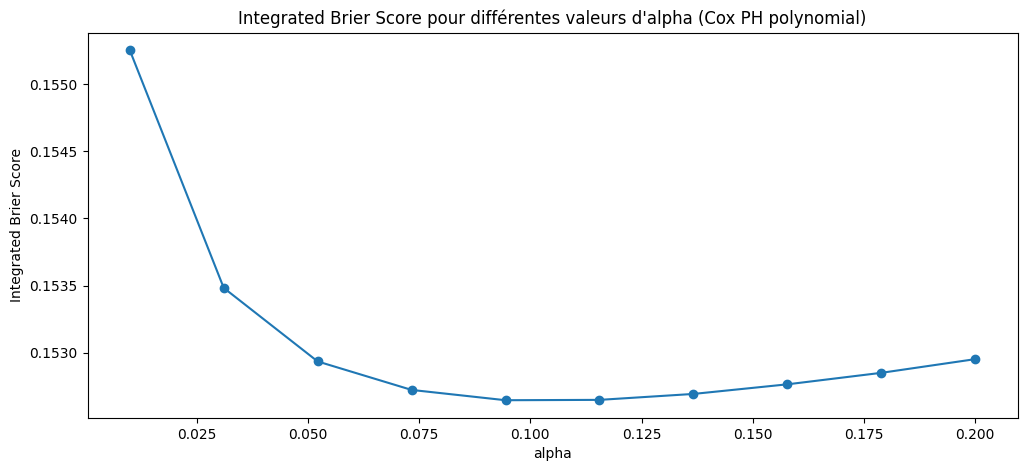

In [199]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import SplineTransformer
from sklearn.pipeline import make_pipeline
from sklearn.kernel_approximation import Nystroem
from sklearn.compose import ColumnTransformer
from sklearn.metrics import auc

# Liste des valeurs d'alpha entre 0.01 et 0.2, en 10 étapes
alpha_values = np.linspace(0.01, 0.2, 10)

# Créer un préprocesseur pour appliquer SplineTransformer aux colonnes spécifiques
column_transformer = ColumnTransformer(
    transformers=[
        ('spline', SplineTransformer(), ['x0', 'x1', 'x2', 'x3', 'x8']),
        ('passthrough', 'passthrough', [col for col in X_train.columns if col not in ['x0', 'x1', 'x2', 'x3', 'x8']])
    ])

# Dictionnaire pour stocker les IBS pour chaque valeur de alpha
ibs_per_alpha = {}

# Boucle pour tester différentes valeurs de alpha
for alpha in alpha_values:
    # Création du pipeline avec chaque valeur de alpha
    poly_cox_ph = make_pipeline(
        column_transformer,
        Nystroem(kernel="poly", degree=2, n_components=300),
        CoxPHSurvivalAnalysis(alpha=alpha)
    )
    
    # Entraînement du modèle
    poly_cox_ph.fit(X_train, as_sksurv_recarray(y_train))

    # Prédictions de survie sur les données de test
    poly_cox_ph_survival_funcs = poly_cox_ph.predict_survival_function(X_test)
    y_pred_poly_cox_ph_test = np.vstack([func(time_grid) for func in poly_cox_ph_survival_funcs])

    # Calcul de l'IBS
    _, poly_cox_ph_brier_scores = brier_score(
        survival_train=as_sksurv_recarray(y_train),
        survival_test=as_sksurv_recarray(y_test),
        estimate=y_pred_poly_cox_ph_test,
        times=time_grid,
    )
    ibs = auc(time_grid, poly_cox_ph_brier_scores) / (time_grid[-1] - time_grid[0])
    ibs_per_alpha[alpha] = ibs

# Tracer les résultats
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(list(ibs_per_alpha.keys()), list(ibs_per_alpha.values()), marker='o')
ax.set(
    title="Integrated Brier Score pour différentes valeurs d'alpha (Cox PH polynomial)",
    xlabel="alpha",
    ylabel="Integrated Brier Score",
    xscale="linear"
)
plt.show()


Nous retenons la valeur de *0.1* comme valeur de alpha qui optimise l'IBS.  
Ajoutons le modèle Cox polynomial avec cette valeur d'alpha aux autres modèles pour comparaison.

,Model,IBS,C-index
0,Constant linear,0.1754,0.5000
1,Kaplan-Meier,0.1753,0.5000
2,Cox PH,0.1565,0.6299
3,Polynomial Cox PH,0.1526,0.6486


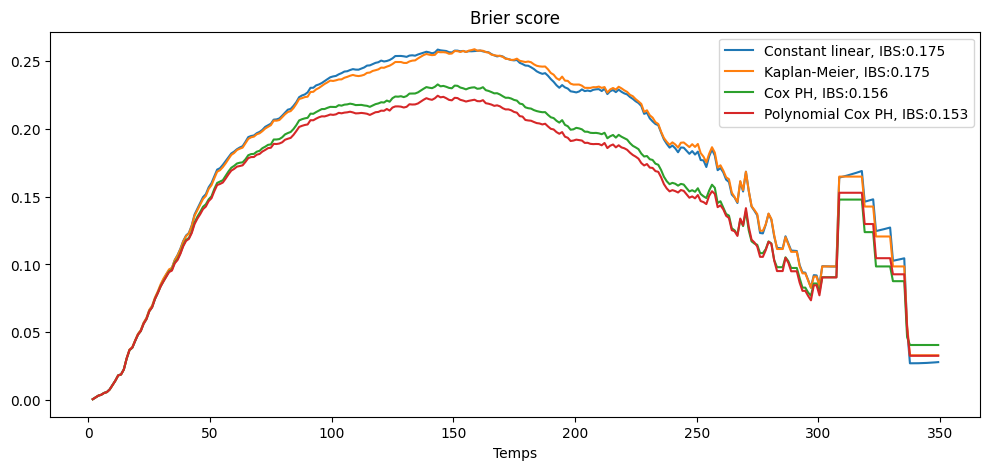

In [256]:
from sklearn.preprocessing import SplineTransformer
from sklearn.pipeline import make_pipeline
from sklearn.kernel_approximation import Nystroem
from sklearn.compose import ColumnTransformer

# Créer un préprocesseur pour appliquer SplineTransformer uniquement aux colonnes x0, x1, x2, x3 et x8
column_transformer = ColumnTransformer(
    transformers=[
        ('spline', SplineTransformer(), ['x0', 'x1', 'x2', 'x3', 'x8']),  # Appliquer SplineTransformer
        ('passthrough', 'passthrough', [col for col in X_train.columns if col not in ['x0', 'x1', 'x2', 'x3', 'x8']])  # Passer les autres colonnes
    ])

# Créer un pipeline avec le ColumnTransformer, Nystroem et le modèle CoxPH
poly_cox_ph = make_pipeline(
    column_transformer,
    Nystroem(kernel="poly", degree=2, n_components=300),
    CoxPHSurvivalAnalysis(alpha=1e-1)
)

# Entraînement du modèle sur les données d'entraînement
poly_cox_ph.fit(X_train, as_sksurv_recarray(y_train))

# Prédiction des fonctions de survie sur les données de test
poly_cox_ph_survival_funcs = poly_cox_ph.predict_survival_function(X_test)
poly_cox_ph_survival_curves = np.vstack(
    [
        poly_cox_ph_survival_func(time_grid)
        for poly_cox_ph_survival_func in poly_cox_ph_survival_funcs
    ]
)
evaluator("Polynomial Cox PH", poly_cox_ph_survival_curves)


Par rapport au modèle de Cox simple, le modèle de Cox polynimial fait mieux sur les deux métriques mais la différence est minime.  
Le temps de calcul est plus long. 
L'intêret de cette méthode est à discuter au cas par cas, selon le type d'étude (quelle précision est recherchée par exemple) et selon la complexité des données.   
Non représenté ici: nous avons testé d'autres valeurs de degré de polynomes, le degré 2 est celui qui offrait le meilleur compromis sur les métriques et le temps de calcul.

# Random survival forest

Le Random Survival Forest (RSF) est une application à l'analyse de survie des forêts aléatoires appliquée.   
C'est une modélisation non parmétrique ce qui accroit la flexibilité et permet de capturer des relations complexes entre les covariables (y compris les interactions) et le temps de survie.  
En combinant plusieurs arbres de décision, cette approche réduit le risque de surajustement ce qui augmente donc sa robustesse.

In [239]:
from sksurv.ensemble import RandomSurvivalForest
rsf = RandomSurvivalForest(n_estimators=100, max_depth=8, n_jobs=-1)  # "n_estimators=10" : Nombre d'arbres dans la forêt  "n_jobs=-1" : 

# Entraînement du modèle
rsf.fit(X_train, as_sksurv_recarray(y_train))

RandomSurvivalForest(max_depth=8, n_jobs=-1)

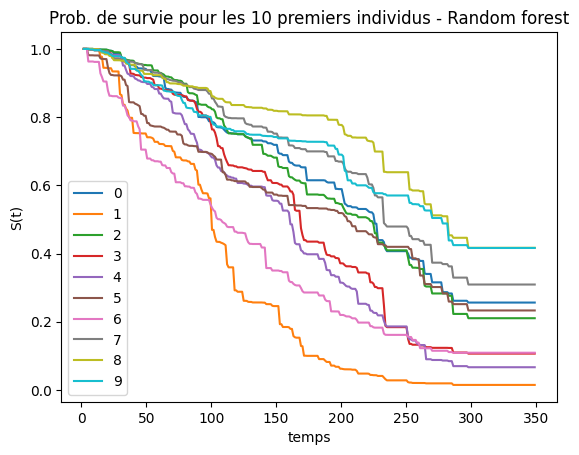

In [243]:
# prédiciton sur X_test du modèle rsf
rsf_survival_funcs = rsf.predict_survival_function(X_test) 

fig, ax = plt.subplots()
for idx, survival_func in enumerate(rsf_survival_funcs[:10]):
    survival_curve = survival_func(time_grid)
    ax.plot(time_grid, survival_curve, label=idx)
ax.set(
    title="Prob. de survie pour les 10 premiers individus - Random forest",
    xlabel="temps",
    ylabel="S(t)",
)
plt.legend();

Les résultats sont assez différents de ceux obtenus avec le modèle de Cox.  
L’individu 1 en est un bon exemple: dans ce modèle, il présente les probabilités de survie les plus faibles, alors que c'est l'individu 4 dans le modèle de Cox.  
Les courbes de survie se croisent davantage avec le modèle rsf, ce qui indique probablement une plus grande flexibilité par rapport aux modèles précédents.

,Model,IBS,C-index
0,Constant linear,0.1754,0.5000
1,Kaplan-Meier,0.1753,0.5000
2,Cox PH,0.1565,0.6299
3,Polynomial Cox PH,0.1526,0.6486
4,Random Survival Forest,0.1611,0.6302


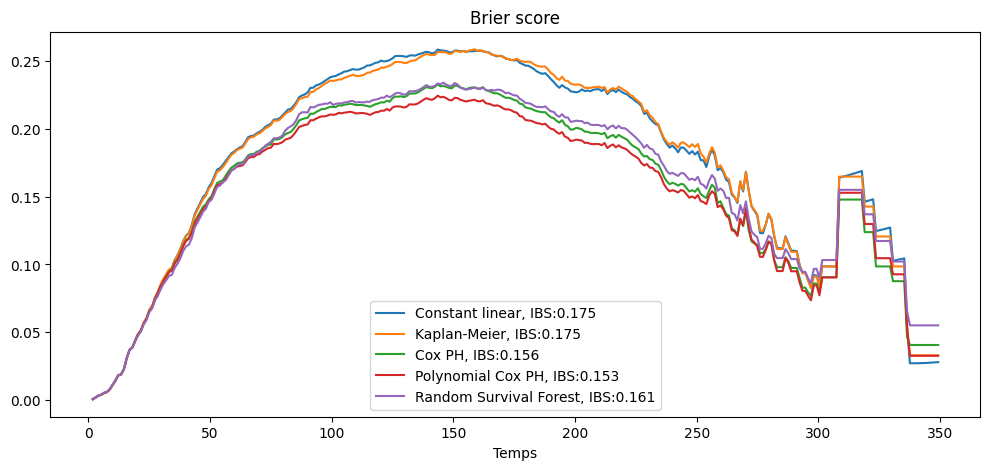

In [257]:
rsf_survival_curves = np.vstack(
    [func(time_grid) for func in rsf_survival_funcs]
)
evaluator("Random Survival Forest", rsf_survival_curves)

Le modèle *rsf* se positionne en troisème position sur les deux métriques utilisées, derrière les dux modèle de Cox.


# Conclusion

Pour nos données, c'est le modèle de Cox polynomial qui obtient les meilleurs résultats.  
Calculons les prédicitons de survie pour les 10 premiers individus de X_test:

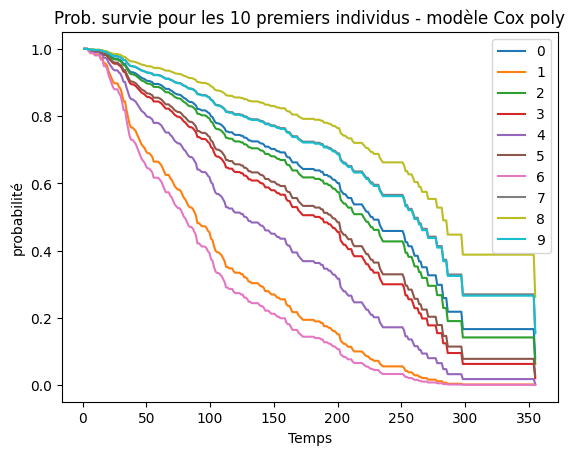

In [258]:
# Entraînement du modèle sur les données d'entraînement
poly_cox_ph.fit(X_train, as_sksurv_recarray(y_train))

# Prédiction des fonctions de survie sur les données de test
poly_cox_ph_survival_funcs = poly_cox_ph.predict_survival_function(X_test)

# Graphique des probabilités de survie pour les 10 premières observations de X_test
fig, ax = plt.subplots()
time_grid = np.linspace(y_train['duration'].min(), y_train['duration'].max(), num=300)

for idx, poly_cox_ph_survival_func in enumerate(poly_cox_ph_survival_funcs[:10]):
    survival_curve = poly_cox_ph_survival_func(time_grid)
    ax.plot(time_grid, survival_curve, label=idx)

ax.set(
    title="Prob. survie pour les 10 premiers individus - modèle Cox poly",
    xlabel="Temps",
    ylabel="probabilité",
)
plt.legend()
plt.show()
